# 따릉이 대여량 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [2]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
# 한글폰트
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


In [3]:
train = pd.read_csv('data/train.csv', parse_dates=["date_time"])

- date_time : 일별 날짜
- wind_direction: 풍향 (degree)
- sky_condition : 하늘 상태 (하단 설명 참조)
- precipitation_form : 강수 형태 (하단 설명 참조)
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

- 기상 데이터는 하루에 총 8번 3시간 간격으로 발표되는 기상단기예보(SHRT) 데이터를 1일 평균으로 변환한 데이터입니다.
- 2019년 6월 4일 까지 sky_condition (하늘 상태) 코드  : 맑음(1), 구름조금(2), 구름많음(3), 흐림(4)
- 2020년  sky_condition (하늘 상태) 코드  : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form (강수 형태) 코드 : 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
- 원본 데이터에는 없음(0), 비(1),소나기(4)가 포함되어있었으며 진눈깨비(2)와 눈(3) 성분은 존재하지 않습니다.

In [4]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


### 데이터크기
273개의 행과과 10개의 컬럼을 가지고 있다.

In [5]:
train.shape

(273, 10)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_time                  273 non-null    datetime64[ns]
 1   wind_direction             273 non-null    float64       
 2   sky_condition              273 non-null    float64       
 3   precipitation_form         273 non-null    float64       
 4   wind_speed                 273 non-null    float64       
 5   humidity                   273 non-null    float64       
 6   low_temp                   273 non-null    float64       
 7   high_temp                  273 non-null    float64       
 8   Precipitation_Probability  273 non-null    float64       
 9   number_of_rentals          273 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 21.5 KB


### 결측치 파악
결측치가 존재하지 않습니다.

In [7]:
train.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

### 데이터 전처리
date_time를 나누어 year(년),month(월),day(일),weekday(평일,주말)로 나누어 주자.

In [8]:
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month
train["day"] = train["date_time"].dt.day
train["weekday"] = train["date_time"].dt.weekday
train.shape

(273, 14)

칼럼 10개에서 14개로 늘어난걸 확인 할 수 있다.

In [9]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3


## 시각화
- 년도별 그래프를 보면 매년마다 대여량이 많아지는걸 볼 수 있다.
- 4,5,6월 그래프를 보면 날씨가 따뜻해질수록 대여량이 많아지는걸 볼 수 있다.
- 일별 그래프는 특징을 찾기 어려운거 같다.
- 요일별 그래프는 대여량이 월~토는 비슷하며 일요일은 미미하게 적은걸 확인 할 수 있다.

[Text(0.5, 0, 'weekday'), Text(0.5, 1.0, '요일별 대여량')]

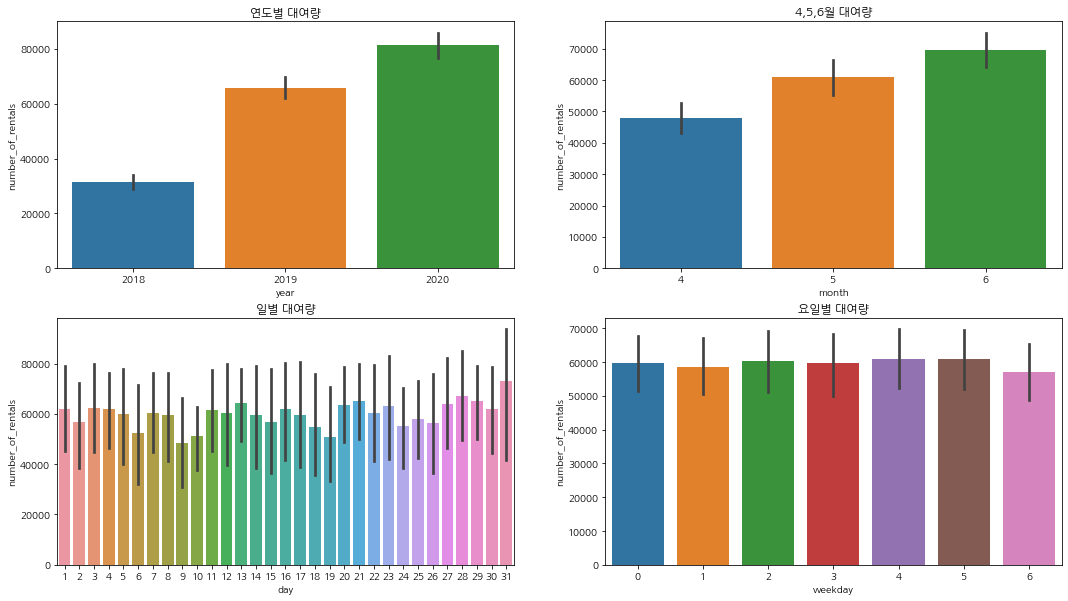

In [10]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,10)

sns.barplot(data=train, x="year", y="number_of_rentals", ax=ax1)
sns.barplot(data=train, x="month", y="number_of_rentals", ax=ax2)
sns.barplot(data=train, x="day", y="number_of_rentals", ax=ax3)
sns.barplot(data=train, x="weekday", y="number_of_rentals", ax=ax4)

ax1.set(ylabel='number_of_rentals',title="연도별 대여량")
ax2.set(xlabel='month',title="4,5,6월 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='weekday', title="요일별 대여량")

<AxesSubplot:>

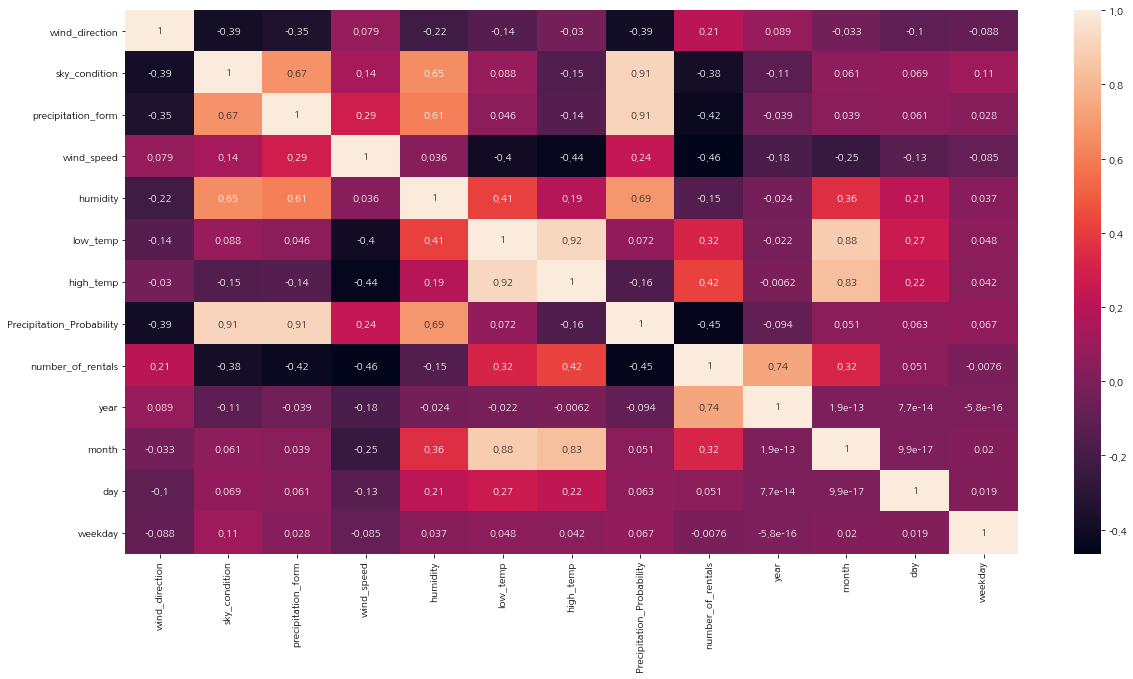

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(train.corr(), annot = True)

Text(0.5, 1.0, '날씨별 대여량')

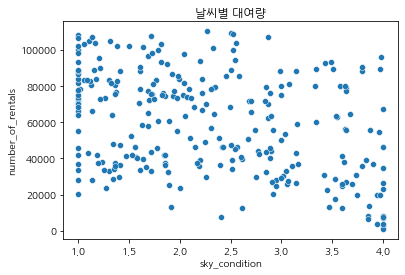

In [12]:
sns.scatterplot(data=train, x='sky_condition', y='number_of_rentals')
plt.title("날씨별 대여량")

날씨에 따른 대여량을 보면 맑음에 많은 대여량을 확인 할 수 있다.

Text(0.5, 1.0, '강수 형태에 따른 대여량')

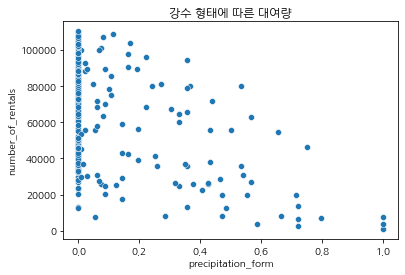

In [13]:
sns.scatterplot(data=train, x='precipitation_form', y='number_of_rentals',)
plt.title("강수 형태에 따른 대여량")

강수 형태에 따른 대여량을 보면 비가 안올때 자전거 대여량이 당연히 많이 모여있음을 알 수 있다.

Text(0.5, 1.0, '강수 확률에 따른 대여랑')

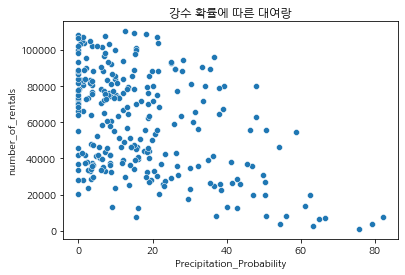

In [14]:
sns.scatterplot(data=train, x='Precipitation_Probability', y='number_of_rentals',)
plt.title("강수 확률에 따른 대여랑")

강수 확률에 따른 대여량 역시 확률이 낮은 쪽에 대여량이 많이 몰려 있는것을 확인 할 수 있다.

Text(0.5, 1.0, '강수 확률에 따른 대여랑')

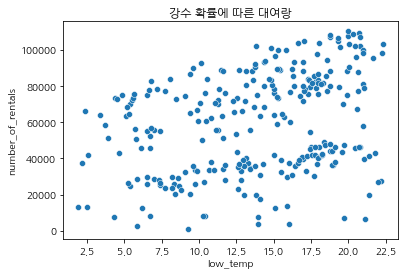

In [15]:
sns.scatterplot(data=train, x='low_temp', y='number_of_rentals',)
plt.title("강수 확률에 따른 대여랑")

Text(0.5, 1.0, '강수 확률에 따른 대여랑')

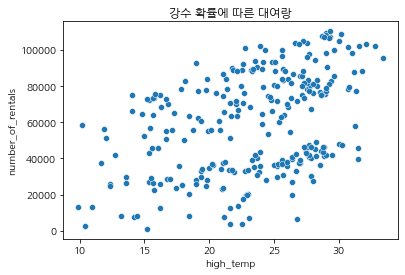

In [16]:
sns.scatterplot(data=train, x='high_temp', y='number_of_rentals',)
plt.title("강수 확률에 따른 대여랑")

## 변수 및 모델 정의
우리의 목적은 주어진 날시 데이터를 이용해 따릉이 대여량을 예측하는 것입니다.<br>
날시 데이터가 X, 따릉이 대여 수가 y가 되야 한다.

In [17]:
train = pd.read_csv('data/train.csv')

In [18]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point)-2017)
        month.append(int(month_point)-3)
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(train)

train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,1,1,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,1,1,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,1,1,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,1,1,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,1,1,5


In [19]:
X = train.drop(['date_time', 'number_of_rentals'], axis=1)
y = train.number_of_rentals

In [20]:
X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,1
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,2
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,3
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,4
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,3,3,26
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,3,3,27
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,3,3,28
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,3,3,29


## 0.oringinal model성능 확인

In [21]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y) 

LinearRegression()

In [23]:
y_hat = model.predict(X)

In [24]:
score = NMAE(y, y_hat)

print(f'모델 NMAE:{score}')

모델 NMAE:0.3234797521201453


오차율이 32%정도로 나왔다.

## 1. Feature Engineering by human
### 요일정보,온도 정보 추가
- 1. 일교차가 너무 큰 날씨
- 2. 너무 덥고 습한 날씨
- 3. 춥고 바람부는 날씨

In [25]:
X_human = X.copy()

In [26]:
# 요일 정보 추가
week_day = pd.to_datetime(train['date_time']).dt.day_name()
le = LabelEncoder()
le.fit(week_day)
X_human['week_day'] = le.transform(week_day)
X_human.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week_day
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,1,3
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,2,1
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,3,5
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,4,6
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,5,4


In [27]:
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_human['temp_diff_info'] = X_human['high_temp'] - X_human['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_human['sweat_info'] = X_human['high_temp'] * X_human['humidity']

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_human['cold_info'] = X_human['low_temp'] * X_human['wind_speed']

X_human.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week_day,temp_diff_info,sweat_info,cold_info
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,1,3,8.400,1575.000000,38.430000
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,2,1,6.188,1326.827000,41.997736
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,3,5,5.004,1146.846764,27.739280
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,4,6,4.056,888.628432,26.083056
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,5,4,4.546,768.903064,18.717750


In [28]:
## 1번 모델 성능 확인
model = LinearRegression() # 모델 정의
model.fit(X_human, y) # 학습

y_hat = model.predict(X_human) # 예측

score = NMAE(y, y_hat)

print(f'모델 NMAE:{score}')

모델 NMAE:0.28426261278332


오차율이 32%에서 4%가량 성능 향상이되어 28%정도 인것을 확인할 수 있다.

## 2. Feature Engineering by Computer

이번에는 사람의 판단이 들어가지 않고 오로지 컴퓨터의 단순 계산만을 이용해 feature를 추가해보자.<br>
sklearn 에서 제공하는 feature engineering이 이런 방식입니다.<br>
두 변수간의 곱을 추가해준 다음 성능 비교를 해봅시다.

In [29]:
X_computer = X.copy()

In [30]:
col_list = X_computer.columns

# 이중 for문을 사용하여 feature 자기 자신의 제곱과 두 feature간의 곱이라는 새로운 feature를 추가해줍니다.
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X_computer[f'{col_list[i]}*{col_list[j]}'] = X_computer[col_list[i]]*X_computer[col_list[j]]
        
X_computer

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,...,Precipitation_Probability*Precipitation_Probability,Precipitation_Probability*year,Precipitation_Probability*month,Precipitation_Probability*day,year*year,year*month,year*day,month*month,month*day,day*day
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,...,900.000000,30.000,30.000,30.000,1,1,1,1,1,1
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,...,380.250000,19.500,19.500,39.000,1,1,2,1,2,4
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,...,365.306769,19.113,19.113,57.339,1,1,3,1,3,9
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,...,1891.641049,43.493,43.493,173.972,1,1,4,1,4,16
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,...,4016.770884,63.378,63.378,316.890,1,1,5,1,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,3,3,...,1331.228196,109.458,109.458,948.636,9,9,78,9,78,676
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,3,3,...,444.408561,63.243,63.243,569.187,9,9,81,9,81,729
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,3,3,...,53.246209,21.891,21.891,204.316,9,9,84,9,84,784
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,3,3,...,241.522681,46.623,46.623,450.689,9,9,87,9,87,841


원래 11개만 있던 feature가 77개로 늘어난걸 확인 할 수 있다.

In [31]:
model = LinearRegression()  
model.fit(X_computer, y) 

y_hat = model.predict(X_computer) 

score = NMAE(y, y_hat)

print(f'모델 NMAE: {score}')

모델 NMAE: 0.1401335572793782


기존 모델 32% 보다 18% 줄어든 14% 많이 향상 되었음을 확인 할 수 있다.

## 3. Feature Engineering by Human & Computer

2번에서 컴퓨터로만 한것과 1번에서 추가한 정보를 통해 방식을 혼용해보자.

In [32]:
X_combination = X.copy()

#### 요일정보,온도정보를 추가해주자.

In [33]:
# 요일 정보 추가
week_day=  pd.to_datetime(train['date_time']).dt.day_name()
le = LabelEncoder()
le.fit(week_day)
X_combination['week_day'] = le.transform(week_day)
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
X_combination['temp_diff_info'] = X_combination['high_temp'] - X_combination['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
X_combination['sweat_info'] = X_combination['high_temp'] * X_combination['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
X_combination['cold_info'] = X_combination['low_temp'] * X_combination['wind_speed']


In [34]:
col_list = X_combination.columns

# 이중 for문을 사용하여 변수 자기 자신의 제곱과 두 변수간의 곱이라는 새로운 변수를 추가합니다.
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X_combination[f'{col_list[i]}*{col_list[j]}'] = X_combination[col_list[i]] * X_combination[col_list[j]]
        
X_combination

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,...,week_day*week_day,week_day*temp_diff_info,week_day*sweat_info,week_day*cold_info,temp_diff_info*temp_diff_info,temp_diff_info*sweat_info,temp_diff_info*cold_info,sweat_info*sweat_info,sweat_info*cold_info,cold_info*cold_info
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,1,1,...,9,25.200,4725.000000,115.290000,70.560000,13230.000000,322.812000,2.480625e+06,60527.250000,1476.864900
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,1,1,...,1,6.188,1326.827000,41.997736,38.291344,8210.405476,259.881990,1.760470e+06,55723.730064,1763.809829
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,1,1,...,25,25.020,5734.233820,138.696400,25.040016,5738.821207,138.807357,1.315258e+06,31812.703504,769.467655
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,1,1,...,36,24.336,5331.770592,156.498336,16.451136,3604.276920,105.792875,7.896605e+05,23178.145155,680.325810
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,1,1,...,16,18.184,3075.612256,74.871000,20.666116,3495.433329,85.090891,5.912119e+05,14392.135326,350.354165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,3,3,...,0,0.000,0.000000,0.000000,49.364676,15158.123050,327.098943,4.654516e+06,100440.364024,2167.414580
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,3,3,...,4,16.060,4523.117808,74.673456,64.480900,18160.317999,299.813926,5.114649e+06,84439.209655,1394.031258
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,3,3,...,9,24.159,6339.597024,114.660000,64.850809,17017.591611,307.785660,4.465610e+06,80766.466086,1460.768400
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,3,3,...,1,6.375,1832.298000,40.093875,40.640625,11680.899750,255.598453,3.357316e+06,73463.926975,1607.518813


feature가 135개로 늘어난걱 확인 할 수 있다.

In [35]:
## 3번 모델 성능 확인

model = LinearRegression() # 모델 정의
model.fit(X_combination, y) # 학습

y_hat = model.predict(X_combination) # y 예측

score = NMAE(y, y_hat)

print(f'모델 NMAE: {score}')

모델 NMAE: 0.10278949922522818


결과를 보면 성능이 험청 상향 된걸 확인 할 수 있다. 기존 모델과 오차율이 22%, 2번모델과 4% 정도 차이의 성능을 보여준다.<br>
결과를 보면 컴퓨터만 단순계산보다 정보를 추가해 혼용한것이 성능이 좋은 것을 알 수 있다.

## 4.Submission 제출
### test set 전처리

In [36]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [37]:
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459


In [38]:
test.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
dtype: int64

In [39]:
 year, month, day = seperate_datetime(test)
    
test['year'] = year
test['month'] = month
test['day'] = day

# date_time은 제거
test_X = test.drop('date_time', axis = 1)

In [40]:
test_X.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,4,1,1
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,4,1,2
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,4,1,3
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,4,1,4
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,4,1,5


year,month,day는 잘 추가 되었고 date_time는 잘 제거가 되었다.

#### 요일 정보, 온도정보 추가

In [41]:
week_day = pd.to_datetime(test['date_time']).dt.day_name()
le = LabelEncoder()
le.fit(week_day)
test_X['week_day'] = le.transform(week_day)

# 일교차가 너무 큰 날씨
test_X['temp_diff_info'] = test_X['high_temp'] = test_X['low_temp']

# 덥고 습한 날씨
test_X['sweat_info'] = test_X['high_temp']*test_X['humidity']

# 춥고 바람부는 날씨
test_X['cold_info'] = test_X['low_temp']*test_X['wind_speed']

test_X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week_day,temp_diff_info,sweat_info,cold_info
0,108.833,3.000,0.000,2.900,28.333,11.800,11.800,18.333,4,1,1,4,11.800,334.329400,34.220000
1,116.717,3.850,0.000,2.662,46.417,12.000,12.000,28.500,4,1,2,0,12.000,557.004000,31.944000
2,82.669,4.000,0.565,2.165,77.258,8.875,8.875,52.847,4,1,3,2,8.875,685.664750,19.214375
3,44.123,3.466,0.466,3.747,63.288,6.250,6.250,37.671,4,1,4,3,6.250,395.550000,23.418750
4,147.791,1.500,0.000,1.560,48.176,7.188,7.188,4.459,4,1,5,1,7.188,346.289088,11.213280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,177.149,3.980,0.223,1.066,74.628,20.312,20.312,36.486,4,3,26,2,20.312,1515.843936,21.652592
87,138.723,2.777,0.135,1.290,70.236,20.812,20.812,18.378,4,3,27,3,20.812,1461.751632,26.847480
88,111.095,3.338,1.270,1.692,70.338,21.000,21.000,35.946,4,3,28,1,21.000,1477.098000,35.532000
89,171.622,3.270,0.595,1.470,70.473,21.000,21.000,27.770,4,3,29,5,21.000,1479.933000,30.870000


In [42]:
col_list = test_X.columns

for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        test_X[f'{col_list[i]}*{col_list[j]}'] = test_X[col_list[i]]*test_X[col_list[j]]
test_X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,...,week_day*week_day,week_day*temp_diff_info,week_day*sweat_info,week_day*cold_info,temp_diff_info*temp_diff_info,temp_diff_info*sweat_info,temp_diff_info*cold_info,sweat_info*sweat_info,sweat_info*cold_info,cold_info*cold_info
0,108.833,3.000,0.000,2.900,28.333,11.800,11.800,18.333,4,1,...,16,47.200,1337.317600,136.880000,139.240000,3945.086920,403.796000,1.117761e+05,11440.752068,1171.008400
1,116.717,3.850,0.000,2.662,46.417,12.000,12.000,28.500,4,1,...,0,0.000,0.000000,0.000000,144.000000,6684.048000,383.328000,3.102535e+05,17792.935776,1020.419136
2,82.669,4.000,0.565,2.165,77.258,8.875,8.875,52.847,4,1,...,4,17.750,1371.329500,38.428750,78.765625,6085.274656,170.527578,4.701361e+05,13174.619631,369.192207
3,44.123,3.466,0.466,3.747,63.288,6.250,6.250,37.671,4,1,...,9,18.750,1186.650000,70.256250,39.062500,2472.187500,146.367188,1.564598e+05,9263.286562,548.437852
4,147.791,1.500,0.000,1.560,48.176,7.188,7.188,4.459,4,1,...,1,7.188,346.289088,11.213280,51.667344,2489.125965,80.601057,1.199161e+05,3883.036505,125.737648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,177.149,3.980,0.223,1.066,74.628,20.312,20.312,36.486,4,3,...,4,40.624,3031.687872,43.305184,412.577344,30789.822028,439.807449,2.297783e+06,32821.950282,468.834740
87,138.723,2.777,0.135,1.290,70.236,20.812,20.812,18.378,4,3,...,9,62.436,4385.254896,80.542440,433.139344,30421.974965,558.749754,2.136718e+06,39244.347705,720.787182
88,111.095,3.338,1.270,1.692,70.338,21.000,21.000,35.946,4,3,...,1,21.000,1477.098000,35.532000,441.000000,31019.058000,746.172000,2.181819e+06,52484.246136,1262.523024
89,171.622,3.270,0.595,1.470,70.473,21.000,21.000,27.770,4,3,...,25,105.000,7399.665000,154.350000,441.000000,31078.593000,648.270000,2.190202e+06,45685.531710,952.956900


In [45]:
# train data로 학습시킨 모델에 test_X데이터를 넣고 예측합니다.
test_yhat = model.predict(test_X)

#submission dataFrame 완성
submission['number_of_rentals'] = test_yhat

# 제출 파일 생성
submission.to_csv('submission.csv', index=False)